#                                             PROBLEMA DEL COLOREADO DE GRAFOS                                           #

### Este trabajo ha sido realizado por:

- David Iglesias Dominguez
- Joaquin García Macías

En el curso lectivo 2017/2018, para la asignatura de Inteligencia Artificial, donde se expondrá el codigo que resuelve el problema del coloreado de un grafo cualquiera, dado un número de vértices y colores para colorear, junto con otras variables, encontrando la solución óptima.

Para ello, se resolverá con la técnica de Algoritmos Genéticos, usando mutación de los individuos y enfriamiento simulado

A continuación se muestran las librerias necesarias para el desarrollo del codigo.

Para representar las evaluaciones de los individuos declaramos una clase que herede de la clase `base.Fitness` y en la que establezcamos en el atributo `weights` una tupla con los valores de los pesos, como números reales. 

In [3]:
import random
from deap import base, creator, tools, algorithms
import numpy
import networkx as nx
import matplotlib.pyplot as plt

creator.create('Fitness', base.Fitness, weights=(-1.0,))
creator.create('Individuo', list, fitness = creator.Fitness)

C:\ProgramData\Anaconda3\lib\site-packages\deap-1.2.2-py3.6.egg\deap\creator.py:141: RuntimeWarning: A class named 'Fitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
C:\ProgramData\Anaconda3\lib\site-packages\deap-1.2.2-py3.6.egg\deap\creator.py:141: RuntimeWarning: A class named 'Individuo' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.


En este primer apartado, solicitamos las variables necesarias para realizar el proyecto, en ellas se incluyen, el numero de colores, nodos e individuos, que guardaremos en variables globales para poder utilizarlas a continuacion.

Del mismo modo, creamos una _caja de herramientas (_toolbox_) en la que registremos todos los elementos necesarios para poder aplicar un algoritmo genético.

In [4]:
caja_de_herramientas = base.Toolbox()
global numColores
numColores = int(input('Introduce el número de colores: '))
caja_de_herramientas.register('gen', random.randint, 1, numColores)
global numNodos
numNodos = int(input('Introduce el número de nodos: '))
caja_de_herramientas.register('individuo', tools.initRepeat,
                              container=creator.Individuo, func=caja_de_herramientas.gen, n=numNodos)
global numIndividuos # Para enfriamiento simulado se puede bajar el número
numIndividuos = int(input('Introduce el número de individuos de cada población: '))
caja_de_herramientas.register('población', tools.initRepeat,
                              container=list, func=caja_de_herramientas.individuo, n=numIndividuos)

Introduce el número de colores: 5
Introduce el número de nodos: 5
Introduce el número de individuos de cada población: 5


A continuacion declaramos una variable globla para el grafo, que tendra los nodos solicitados anteriormente, y será de tipo completo, usando la libreria networkx.

También se muestran todos los posibles grafos que se pueden crear y utilizar con esta libreria.

In [8]:
global grafo
grafo = nx.complete_graph(numNodos) # PRUEBA 1: 200 NODOS
# grafo = nx.erdos_renyi_graph(numNodos, 0.15) # PRUEBA 2: 80 NODOS, PRUEBA 3-4: 20 NODOS
# grafo = nx.petersen_graph() # PRUEBA 5-8: 10 NODOS

In [ ]:
# Métodos para crear grafos
petersen = nx.petersen_graph() # 10 nodos
tutte = nx.tutte_graph() # 46 nodos
maze = nx.sedgewick_maze_graph() # 8 nodos
tet = nx.tetrahedral_graph() # 4 nodos
K_5 = nx.complete_graph(5)
K_3_5 = nx.complete_bipartite_graph(3, 5)
barbell = nx.barbell_graph(10, 10)
lollipop = nx.lollipop_graph(10, 20)
er = nx.erdos_renyi_graph(20, 0.15)
ba = nx.barabasi_albert_graph(10, 2)

A continuacion se define el fenotipo que se utiliza en la resolucion del problema, donde recibiremos una lista de colores ( Representa el individuo ), posteriormente, dividiremos en funcion del color asociado al nodo ( El elemento 0 de la lista, correspondiente al primer nodo, tendra un color asociado, y del mismo modo los demas ), de modo que obtendremos en el resultado los nodos dentro de la lista asociada al color que peternecen.

In [152]:
G=globals()
def fenotipo(individuo):
    res = []
    for i in range(1,numColores+1):
        G["P%d"%i] = []
        for j in range(numNodos): 
            if individuo[j] == i:
                G["P%d"%i].append(j)
    for i in range(1,numColores+1):
        res += G["P%d"%i],
    return (res)

Posteriormente declaramos la funcion fitness, que recibira el individuo y llamará al fenotipo para obtener las listas de colores con los nodos.

Posteriormente analizará si, dado un nodo y su color, tiene algun vértice adyacente con el mismo color, en cuyo caso penalizará al individuo.

In [153]:
def evaluar_individuo(individuo):
    fenotipo(individuo)
    penalizacion = 0
    for i in range(1,numColores+1):
        for j in range(len(G["P%d"%i])):
            for k in range(j+1,len(G["P%d"%i])):
                if compruebaVertice(G["P%d"%i][j],G["P%d"%i][k]):
                    penalizacion += 1000
    return (penalizacion,)

def compruebaVertice(a, b):
    res = False
    if b in list(grafo.neighbors(a)):
        res = True
    return res

Una vez definida nuestro fitness y fenotipo, podemos proceder a incluirlos en nuestra caja de herramientas para poder usarla en nuestro algoritmo genético.

In [154]:
caja_de_herramientas.register('evaluate', evaluar_individuo)

A continuacion, se muestra el fragmento de código extraido de la librería DEAP, el cual se encargará de resolver el problema para el algoritmo genético.

In [155]:
def varAnd(population, toolbox, cxpb, mutpb):
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

    return offspring

def eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print (logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print (logbook.stream)

    return population, logbook

Seguidamente, definimos dentro de la caja de herramientas los siguientes parametros necesarios para realizar el algoritmo genético, dado que los algoritmos genéticos implementados en el paquete DEAP esperan que el operador de cruce esté registrado con el nombre `mate` y el operador de mutación con el nombre `mutate`.

Finalmente, como método de selección de individuos registramos en la caja de herramientas el método de selección por torneo, en el que para seleccionar un individuo se elige al azar una cierta cantidad de individuos y de entre ellos se selecciona el más apto. Este método está implementado en la función `selTournament` del módulo `tools`.

Como ejemplo elegimos una poblacion inicial aleatoria sobre la que trabajaremos.

In [138]:
# DEFINICIÓN DE LA MUTACIÓN Y LA POBLACIÓN INCIAL
caja_de_herramientas.register('mate', tools.cxOnePoint)
caja_de_herramientas.register('mutate', tools.mutShuffleIndexes, indpb=0.1)
# indpb es la probabilidad de mutación de cada gen del cromosoma

caja_de_herramientas.register('select', tools.selTournament, tournsize=1)

random.seed(12345)
población_inicial = caja_de_herramientas.población()

print (población_inicial)

[[2, 3, 1, 2, 2, 1, 2, 3, 2, 1], [2, 1, 2, 2, 3, 3, 1, 3, 3, 1], [2, 3, 3, 1, 3, 3, 2, 3, 3, 1], [1, 1, 3, 1, 1, 2, 2, 1, 2, 2], [1, 3, 3, 3, 2, 1, 1, 3, 1, 3], [1, 2, 1, 3, 2, 1, 3, 3, 1, 3], [2, 1, 3, 3, 3, 2, 1, 1, 1, 2], [1, 3, 3, 3, 1, 2, 3, 2, 3, 1], [1, 1, 2, 1, 1, 1, 2, 3, 2, 1], [2, 2, 1, 1, 1, 3, 2, 1, 2, 1], [1, 3, 2, 1, 3, 3, 1, 2, 3, 1], [1, 3, 2, 2, 3, 2, 3, 1, 2, 3], [3, 1, 3, 1, 1, 2, 1, 2, 1, 1], [1, 1, 2, 1, 3, 1, 3, 3, 1, 1], [1, 3, 2, 1, 3, 1, 2, 3, 2, 1], [2, 2, 1, 1, 1, 1, 2, 2, 1, 2], [1, 1, 3, 3, 3, 1, 2, 3, 3, 2], [2, 1, 1, 3, 2, 3, 1, 3, 3, 3], [1, 3, 1, 3, 1, 2, 3, 2, 1, 3], [3, 3, 3, 1, 2, 2, 1, 2, 3, 3]]


Para encontrar las mejores soluciones, utilizaremos el metodo HallOfFame, que muestra las mejores soluciones obtenidas por el algoritmo, en este caso, aunque puedan existir diferentes soluciones válidas, nos quedaremos solo con 1 mejor.

Finalmente, ejecutamos el algoritmo utilizando todos los valores necesarios y establecidos ( Que podran ser introducidos a mano en la interfaz gráfica ), y obtenemos la solucion imprimiendo el grafo mediante la libreria Networkx

gen	nevals
0  	0     
1  	15    
2  	11    
3  	12    
4  	13    
5  	14    
6  	9     
7  	9     
8  	12    
9  	5     
10 	14    
11 	8     
12 	7     
13 	14    
14 	13    
15 	9     
16 	13    
17 	11    
18 	10    
19 	13    
20 	12    
21 	12    
22 	15    
23 	8     
24 	11    
25 	10    
26 	10    
27 	10    
28 	14    
29 	15    
30 	15    
31 	15    
32 	12    
33 	12    
34 	13    
35 	9     
36 	12    
37 	16    
38 	14    
39 	15    
40 	12    
41 	17    
42 	12    
43 	14    
44 	11    
45 	14    
46 	12    
47 	7     
48 	10    
49 	10    
50 	9     
La mejor solucion encontrada ha sido:
Individuo: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]; Fitness: 15000.0


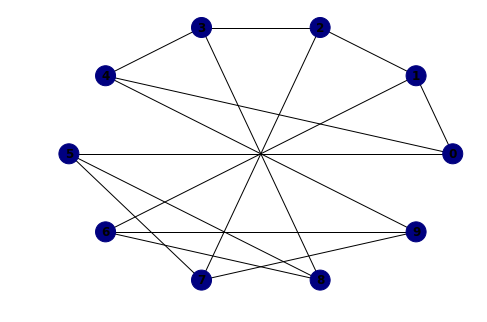

In [193]:
salón_fama = tools.HallOfFame(1)

población, registro = eaSimple(población_inicial,
                                          caja_de_herramientas,
                                          cxpb=0.5, # Probabilidad de que dos individuos contiguos se crucen
                                          mutpb=0.3, # Probabilidad de que un individuo mute
                                          ngen=50, # Número de generaciones
                                          halloffame=salón_fama)

print('La mejor solucion encontrada ha sido:')
solucion = salón_fama[0]
print('Individuo: {1}; Fitness: {0}'.format(
        solucion.fitness.values[0], solucion))
nx.draw_shell(grafo, with_labels=True, font_weight='bold', node_color=solucion, node_size=400, cmap=plt.cm.gist_ncar)
plt.savefig("path.png") # ESTE ULTIMO CODIGO SIRVE PARA GUARDAR LA FIGURA DEL GRAFO Y MOSTRARLO EN LA INTERFAZ.

# ENFRIAMIENTO SIMULADO #

Para realizar el enfriamiento simulado, se utilizará la libreria simanneal, que proporciona los métodos apropiados para el correcto funcionamiento del problema.

In [89]:
from simanneal import Annealer

In [161]:
class GraphColorProblem(Annealer):

    def __init__(self, state):
        super(GraphColorProblem, self).__init__(state)

    def move(self):
        a = random.randint(0, len(self.state) - 1)
        self.state[a] = random.randint(1,3) 

    def energy(self):
        fenotipo(self.state)
        penalizacion = 0
        for i in range(1,numColores+1):
            for j in range(len(G["P%d"%i])):
                for k in range(j+1,len(G["P%d"%i])):
                    if compruebaVertice(G["P%d"%i][j],G["P%d"%i][k]):
                        penalizacion += 1000
        return penalizacion

A continuacion, modificamos las funciones de DEAP utilizadas anteriormente en el algoritmo genético, para poder incluir el enfriamiento simulado, de modo que debemos incluir la llamada al método anterior, junto con los pasos que queremos realizar.

Posteriormente, el método creado ira aplicando el enfriamiento simulado a cada individuo de la población, y lo guardará de nuevo en esta.

In [163]:
def varAndEnfriamiento(population, toolbox, cxpb):
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values
            
    # ENFRIAMIENTO SIMULADO #
    
    for i in range(len(offspring)):
        init_state = offspring[i]
        gcp = GraphColorProblem(init_state)
        gcp.steps = 1
        gcp.updates = 0
        gcp.copy_strategy = "slice"
        state, e = gcp.anneal()
        for j in range(len(offspring[i])):
            offspring[i][j] = state[j]
        del offspring[i].fitness.values

    return offspring

def eaSimpleEnfriamiento(population, toolbox, cxpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print (logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = varAndEnfriamiento(offspring, toolbox, cxpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print (logbook.stream)

    return population, logbook

Volvemos a declarar los elementos necesarios, para ahora, poder realiazr el mismo problema mediante enfriamiento simulado.

In [113]:
caja_de_herramientas.register('mate', tools.cxOnePoint)
caja_de_herramientas.register('mutate', tools.mutShuffleIndexes, indpb=0.1)

caja_de_herramientas.register('select', tools.selTournament, tournsize=1)

random.seed(12345)
población_inicial = caja_de_herramientas.población()

print (población_inicial)

[[2, 3, 1, 2, 2, 1, 2, 3, 2, 1, 2, 1, 2, 2, 3, 3, 1, 3, 3, 1], [2, 3, 3, 1, 3, 3, 2, 3, 3, 1, 1, 1, 3, 1, 1, 2, 2, 1, 2, 2], [1, 3, 3, 3, 2, 1, 1, 3, 1, 3, 1, 2, 1, 3, 2, 1, 3, 3, 1, 3], [2, 1, 3, 3, 3, 2, 1, 1, 1, 2, 1, 3, 3, 3, 1, 2, 3, 2, 3, 1], [1, 1, 2, 1, 1, 1, 2, 3, 2, 1, 2, 2, 1, 1, 1, 3, 2, 1, 2, 1], [1, 3, 2, 1, 3, 3, 1, 2, 3, 1, 1, 3, 2, 2, 3, 2, 3, 1, 2, 3], [3, 1, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 3, 3, 1, 1], [1, 3, 2, 1, 3, 1, 2, 3, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2], [1, 1, 3, 3, 3, 1, 2, 3, 3, 2, 2, 1, 1, 3, 2, 3, 1, 3, 3, 3], [1, 3, 1, 3, 1, 2, 3, 2, 1, 3, 3, 3, 3, 1, 2, 2, 1, 2, 3, 3], [3, 1, 3, 1, 1, 2, 3, 3, 1, 2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2], [3, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 3, 3, 1, 1, 1, 3, 1, 2, 2], [1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1], [2, 2, 1, 1, 1, 1, 3, 1, 2, 2, 2, 1, 1, 1, 2, 1, 3, 1, 2, 3], [3, 2, 1, 3, 2, 1, 1, 1, 3, 1, 3, 3, 3, 2, 3, 1, 3, 1, 3, 3], [2, 3, 1, 2, 2, 2, 1, 2, 3, 1, 2, 2, 3, 3, 3, 3, 1, 2, 2, 2], [1, 2, 

Ejecutamos el codigo, y obtenemos la solucion y realización del enfriamiento simulado individuo a individuo.

La clase Annealer, como podemos observar, posee por defectos los valores de la temperatura inicial y objetivo.

In [172]:
salón_fama = tools.HallOfFame(1)

población, registro = eaSimpleEnfriamiento(población_inicial,
                                          caja_de_herramientas,
                                          cxpb=0.5, # Probabilidad de que dos individuos contiguos se crucen
                                          ngen=50, # Número de generaciones
                                          halloffame=salón_fama)

gen	nevals
0  	0     
1  	20    
2  	20    
3  	20    
4  	20    
5  	20    
6  	20    
7  	20    
8  	20    
9  	20    
10 	20    
11 	20    
12 	20    
13 	20    
14 	20    
15 	20    
16 	20    
17 	20    
18 	20    
19 	20    
20 	20    
21 	20    
22 	20    
23 	20    
24 	20    
25 	20    
26 	20    
27 	20    
28 	20    
29 	20    
30 	20    
31 	20    
32 	20    
33 	20    
34 	20    
35 	20    
36 	20    
37 	20    
38 	20    
39 	20    
40 	20    
41 	20    
42 	20    
43 	20    
44 	20    
45 	20    
46 	20    
47 	20    
48 	20    
49 	20    
50 	20    


Imprimimos de la misma forma que arriba, la solución del problema.

La mejor solucion encontrada ha sido:
Individuo: [2, 1, 2, 3, 1, 3, 3, 1, 2, 2]; Fitness: 0.0


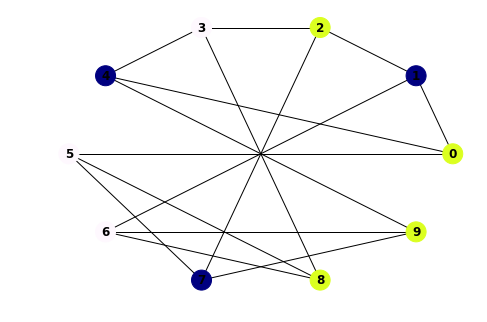

In [173]:
print('La mejor solucion encontrada ha sido:')
for individuo in salón_fama:
    solucion = individuo
    print('Individuo: {1}; Fitness: {0}'.format(
        individuo.fitness.values[0], individuo))
nx.draw_shell(grafo, with_labels=True, font_weight='bold', node_color=solucion, node_size=400, cmap=plt.cm.gist_ncar)
plt.savefig("path.png")